# Исследование моделей для распознавания рукописных цифр из набора MNIST

**Создайте модель для распознавания рукописных цифр из набора MNIST (можно воспользоваться ноутбуком 1-го занятия) и проведите ряд тестов:**

1. Запустите сеть с различными размерами обучающей и проверочной выборок:

    - Обучающая выборка 50.000 примеров
    - Обучающая выборка 10.000 примеров
    - Обучающая выборка 500 примеров

2. Создайте еще два варианта сети и сравните значения точности на проверочной выборке (на последней эпохе) и на тестовой выборке. Сделайте сравнительную таблицу.

3. Создайте сеть следующей архитектуры:

    - 4 Dense слоя
    - Dropout слоя
    - BatchNormalization слоя

Напишите свои выводы по результатам проведенных тестов.

In [1]:
from pathlib import Path
import sys
import time
from typing import List

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import History
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

from PIL import Image
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

Задать количество эпох для обучения.

In [2]:
EPOCHS = 15

Определить вспомогательную функцию для визуализации процесса обучения.

In [3]:
def plot_history(history: History, n: int):
    _, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(
        history.epoch,
        history.history['loss'],
        color='steelblue',
        label='loss'
    )
    axes[0].plot(
        history.epoch,
        history.history['val_loss'],
        color='darkblue',
        label='val_loss'
    )
    axes[0].set_title(f"Изменение loss для $n = {n}$")
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(
        history.epoch,
        history.history['accuracy'],
        color='salmon',
        label='accuracy'
    )
    axes[1].plot(
        history.epoch,
        history.history['val_accuracy'],
        color='darkred',
        label='val_accuracy'
    )
    axes[1].set_title(f"Изменение accuracy для $n = {n}$")
    axes[1].set_ylabel('accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].grid(True)
    axes[1].legend()

    plt.show()

## Подготовка данных

Загрузка данных MNIST:

In [4]:
(x_org, y_org), (x_test_org, y_test_org) = mnist.load_data()

In [5]:
print(f"{x_org.shape}, {x_test_org.shape}")

(60000, 28, 28), (10000, 28, 28)


Отобразить примеры цифр из набора.

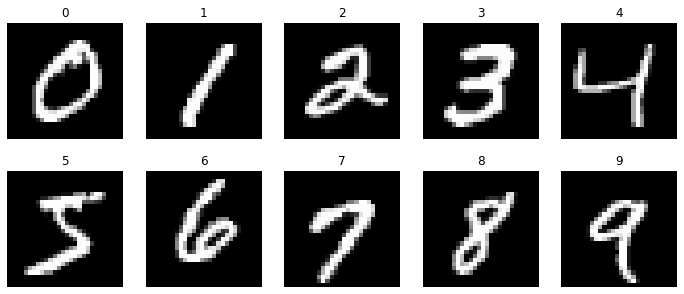

In [6]:
digits = np.unique(y_org)

_, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for digit, ax in zip(digits, axes):
    ax.imshow(
        Image.fromarray(x_org[y_org == digit][0]).convert('RGB')
    )

    ax.set_title(str(digit))
    ax.set_axis_off()

plt.show();

Изменить формат входных изображений:

In [7]:
x = x_org.reshape(-1, 28*28).astype(np.float32) / 255
x_test = x_test_org.reshape(-1, 28*28).astype(np.float32) / 255

Преобразовать ответы в унитарный код (one-hot).

In [8]:
y = utils.to_categorical(y_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

In [9]:
print(f"{y.shape}, {y_test.shape}")

(60000, 10), (10000, 10)


## Исследование влияния объема обучающей выботки на качество обучения нейронной сети

Создать датафрейм для хранения результатов исследования:

In [10]:
report = pd.DataFrame(
    columns=['Train', 'Validation', 'Test', 'Time'],
    index=[50000, 10000, 5000, 1000, 500, 100]
)

### Создание нейронных сетей заданной архитектуры

Вспомогательные классы для создания нейронной сети заданной архитектуры.

In [11]:
class Net(Sequential):

    def __init__(self, *args, **kwargs):
        super(Net, self).__init__(*args, **kwargs)
        self.build()

    def build(self):
        raise NotImplementedError()

    def fit_n(self, x, y, n: int, **kwargs) -> History:
        x_train, x_val, y_train, y_val = train_test_split(
            x,
            y,
            train_size=n
        )

        kwargs['validation_data'] = (x_val, y_val)
        if 'epochs' not in kwargs:
            kwargs['epochs'] = EPOCHS

        return self.fit(
            x_train,
            y_train,
            **kwargs
        )

In [12]:
class SimpleMNISTNet(Net):

    def __init__(self, *args, **kwargs):
        super(SimpleMNISTNet, self).__init__(*args, **kwargs)

    def build(self):
        self.add(Dense(800, input_dim=28*28))
        self.add(Activation('relu'))
        self.add(Dense(400))
        self.add(Activation('relu'))
        self.add(Dense(10))
        self.add(Activation('softmax'))

In [13]:
nets = [SimpleMNISTNet() for _ in report.index]

Выполнить компиляцию нейронных сетей.

In [14]:
for net in nets:
    net.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )

Поскольку все нейронные сети имеют идентичную архитектуру, вывести информацию только о первой из них.

In [15]:
print(nets[0].summary())

Model: "simple_mnist_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 800)               628000    
_________________________________________________________________
activation (Activation)      (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               320400    
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                4010      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 952,410
Trainable params: 952,410
Non-trainable params: 0
____________________________________________

### Обучение нейронных сетей

Произвести обучение всех нейронных сетей из списка.

In [16]:
histories, times = [], []

with tqdm(total=len(nets), desc="Fitting", file=sys.stdout) as pbar:
    for net, n in zip(nets, report.index):
        start = time.clock()
        history = net.fit_n(x, y, n, verbose=0)

        times.append(time.clock() - start)
        histories.append(history)

        pbar.set_description(f"Processed {n}")
        pbar.update()

    pbar.set_description("Done")

Done: 100%|██████████| 6/6 [09:38<00:00, 96.35s/it]


Визуализировать процесс обучения каждой из сетей.

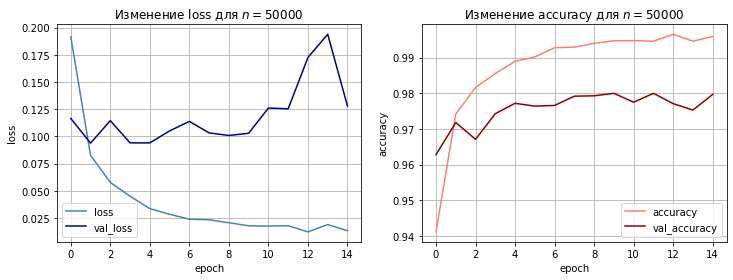

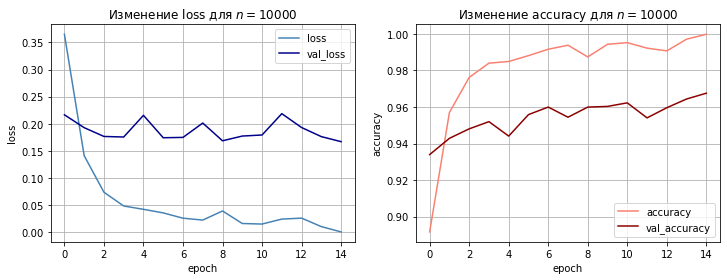

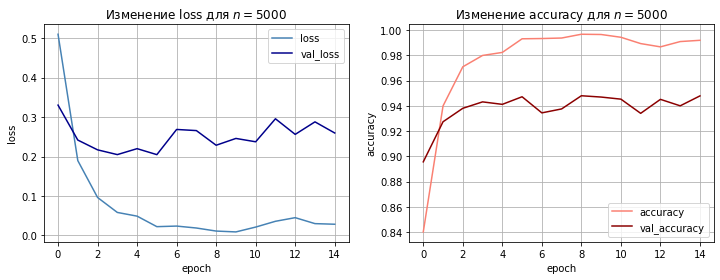

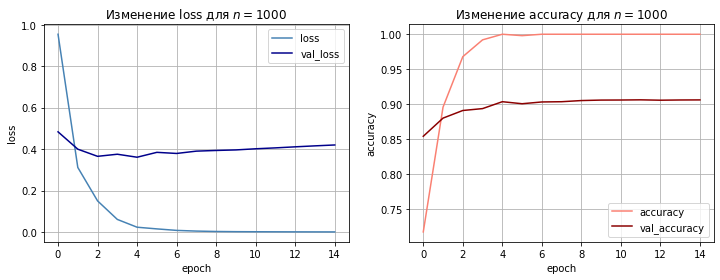

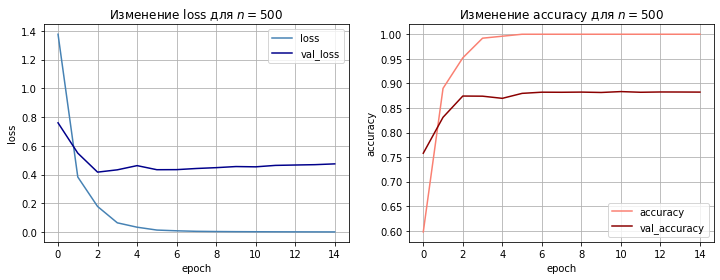

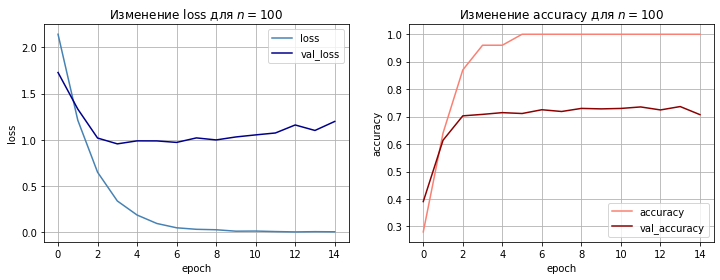

In [17]:
for history, n in zip(histories, report.index):
    plot_history(history, n)

Сохранить веса обученных нейронных сетей.

In [18]:
for net, n in zip(nets, report.index):
    path = Path.home() / f'aiu-02-mnist-light-model-net{n}.h5'

    net.save_weights(path)
    net.load_weights(path)

### Тестирование работы нейронных сетей

Выполнить тестироапние работы каждой из сетей и сохранить результат в таблицу.

In [19]:
with tqdm(total=len(nets), desc='Testing', file=sys.stdout) as pbar:
    for net, n, history, t in zip(nets, report.index, histories, times):
        score = net.evaluate(x_test, y_test, verbose=0)

        report.loc[n, :] = (
            history.history['accuracy'][-1],
            history.history['val_accuracy'][-1],
            score[1],
            t
        )
        pbar.update()

Testing: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


## Исследование влияния объема обучающей выботки на качество обучения нейронной сети c Dropout и BatchNormalization

Создать датафрейм для хранения результатов исследования:

In [20]:
adv_report = pd.DataFrame(
    columns=['Train', 'Validation', 'Test', 'Time'],
    index=[50000, 10000, 5000, 1000, 500, 100]
)

### Создание нейронных сетей заданной архитектуры

Вспомогательный класс для создания нейронной сети заданной архитектуры.

In [21]:
class AdvancedMNISTNet(Net):

    DROPOUT_RATE = 0.5

    def __init__(self, *args, **kwargs):
        super(AdvancedMNISTNet, self).__init__(*args, **kwargs)

    def build(self):
        self.add(Dense(400, input_dim=28*28))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(Dropout(self.DROPOUT_RATE))

        self.add(Dense(200))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(Dropout(self.DROPOUT_RATE))

        self.add(Dense(100))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(Dropout(self.DROPOUT_RATE))

        self.add(Dense(10))
        self.add(Activation('softmax'))

In [22]:
adv_nets = [AdvancedMNISTNet() for _ in adv_report.index]

Выполнить компиляцию нейронных сетей.

In [23]:
for net in adv_nets:
    net.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )

Поскольку все нейронные сети имеют идентичную архитектуру, вывести информацию только о первой из них.

In [24]:
print(adv_nets[0].summary())

Model: "advanced_mnist_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 400)               314000    
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
activation_18 (Activation)   (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 200)               80200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
activation_19 (Activation)   (None, 200)        

### Обучение нейронных сетей

In [25]:
histories, times = [], []

with tqdm(total=len(adv_nets), desc="Fitting", file=sys.stdout) as pbar:
    for net, n in zip(adv_nets, adv_report.index):
        start = time.clock()
        history = net.fit_n(x, y, n, verbose=0)

        times.append(time.clock() - start)
        histories.append(history)

        pbar.set_description(f"Processed {n}")
        pbar.update()

    pbar.set_description("Done")

Done: 100%|██████████| 6/6 [06:39<00:00, 66.62s/it]


Визуализировать процесс обучения каждой из сетей.

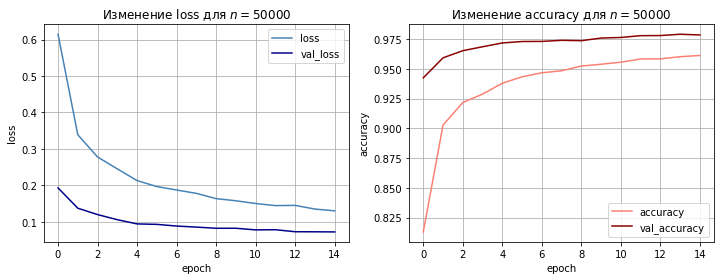

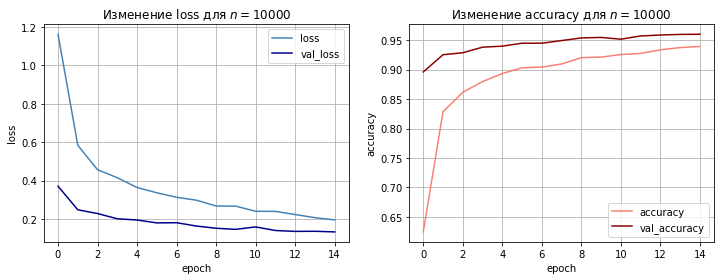

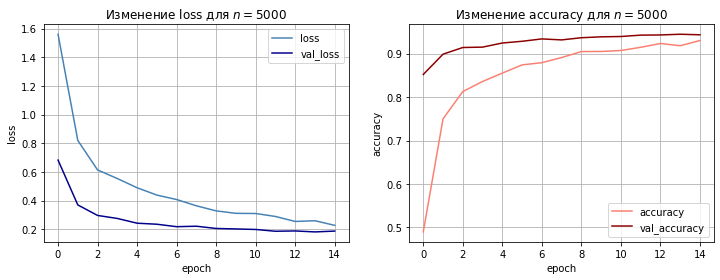

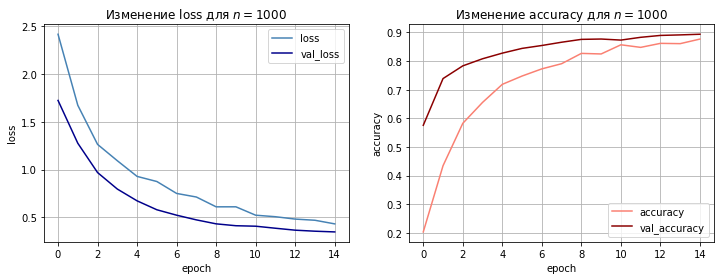

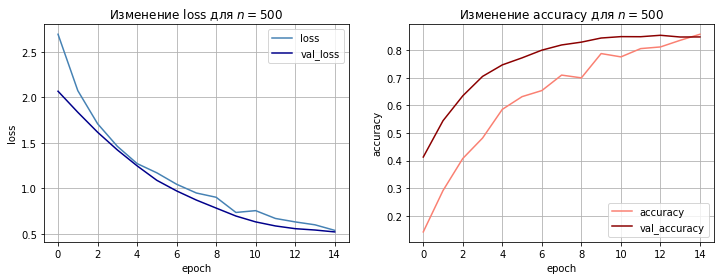

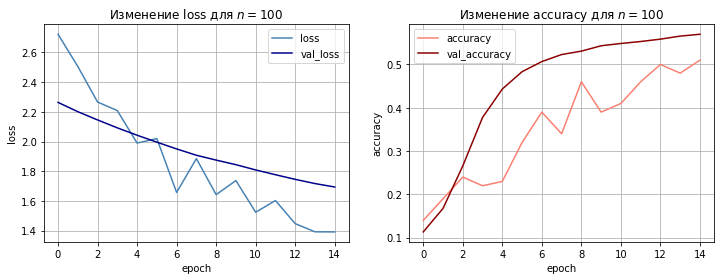

In [26]:
for history, n in zip(histories, adv_report.index):
    plot_history(history, n)

Сохранить веса обученных нейронных сетей.

In [27]:
for net, n in zip(adv_nets, adv_report.index):
    path = Path.home() / f'aiu-02-mnist-light-model-advnet{n}.h5'

    net.save_weights(path)
    net.load_weights(path)

### Тестирование работы нейронных сетей

Выполнить тестироапние работы каждой из сетей и сохранить результат в таблицу.

In [28]:
with tqdm(total=len(adv_nets), desc='Testing', file=sys.stdout) as pbar:
    for net, n, history, t in zip(adv_nets, adv_report.index, histories, times):
        score = net.evaluate(x_test, y_test, verbose=0)

        adv_report.loc[n, :] = (
            history.history['accuracy'][-1],
            history.history['val_accuracy'][-1],
            score[1],
            t
        )
        pbar.update()

Testing: 100%|██████████| 6/6 [00:03<00:00,  1.74it/s]


## Выводы

### Исследование влияния объема обучающей выботки на качаство обучения

Отобразить свобную таблицу для заданной архитектуры нейронной сети.

In [29]:
report

,Train,Validation,Test,Time
50000,0.99594,0.9797,0.9815,151.656
10000,0.9998,0.96756,0.969,88.5163
5000,0.992,0.947964,0.9554,81.1937
1000,1,0.906322,0.9156,93.2508
500,1,0.882336,0.8862,85.0264
100,1,0.707129,0.7054,78.4471


Построить графики завистомости accuracy и времени обучения от объема обучающей выборки.

In [30]:
def plot_report(report: pd.DataFrame):
    _, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].semilogx(
        report.index,
        report.loc[:, 'Train'],
        color='salmon',
        label='Train'
    )
    axes[0].semilogx(
        report.index,
        report.loc[:, 'Validation'],
        color='darkred',
        label='Validation'
    )
    axes[0].semilogx(
        report.index,
        report.loc[:, 'Test'],
        color='orange',
        label='Test'
    )

    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('$n$')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].semilogx(
        report.index,
        report.loc[:, 'Time'],
        color='seagreen',
    )
    axes[1].set_ylabel('Время, сек.')
    axes[1].set_xlabel('$n$')
    axes[1].grid(True)

    plt.show()

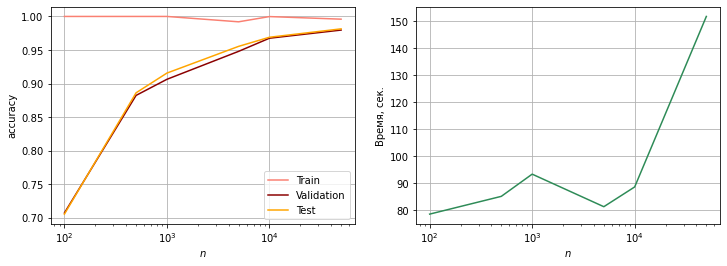

In [31]:
plot_report(report);

Таким образом, на основании проделанных исследований можно сделать выводы, что с увеличением объема обучающей выборки сеть становится все менее переобученной, однако время обучения также растет.

### Исследование влияния объема обучающей выботки на качаство обучения при использовании Dropout и BatchNormalization

Отобразить свобную таблицу для заданной архитектуры нейронной сети.

In [32]:
adv_report

,Train,Validation,Test,Time
50000,0.96116,0.9784,0.9831,128.942
10000,0.9394,0.96012,0.9632,63.16
5000,0.9302,0.943382,0.9504,57.2883
1000,0.877,0.893814,0.9007,50.3262
500,0.858,0.848252,0.8559,52.5258
100,0.51,0.569783,0.5774,47.4775


Построить графики завистомости accuracy и времени обучения от объема обучающей выборки.

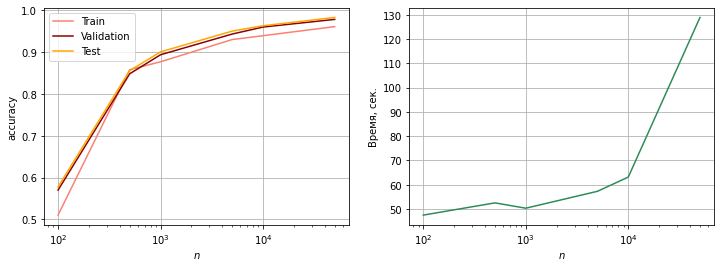

In [33]:
plot_report(adv_report);

Таким образом, введя дополнительные Dropout и BatchNormalization слои удалось практически в два раза сократить число обучаемых параметров и на ныходе получить немного лучшие значения accuracy по сравнению с трехслойной архитектурой без использования Dropout и BatchNormalization. Также с увеличением объема обучающей выборки сеть становится все менее переобученной, однако разрыв между величиной accuracy для обучающей, проверочной и тестовой выборок гораздо меньше. Как и в предыдущем случае с ростом объема обучающей выборки растет и время обучения. 